<a href="https://colab.research.google.com/github/ludo1029/ML-Project-/blob/main/Projet_final_Rotor_Imbalance_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Project: Rotor Imbalance Defect Detection


## 1. Context
Vibration is defined as a cyclic or oscillatory motion. Vibration analysis allows for the detection of defects in rotating machinery before they cause critical failures. The use of machinery vibration and the technological advances that have been developed over the years now  make it possible to not only detect when a machine is developing a problem, but also to identify the specific nature of the problem for scheduled correction.

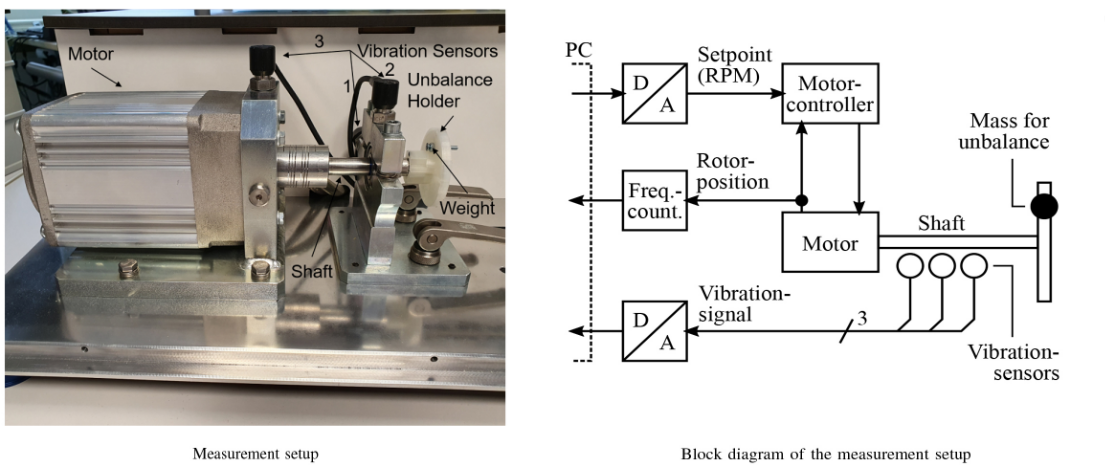

## The DataSet

Vibration data was collected using  a **rotor with different levels of unbalance**, recorded at a **sampling rate of 4096 Hz**.  
Smaller unbalances are harder to detect, as they cause subtler changes in the vibration signals.

In total, there are **5 datasets** representing the unbalance levels:  
- **0** → rotor balanced (no added weight)  
- **1–4** → increasing levels of unbalance, from small to severe  

The rotor speed was varied during measurements:  
- **Development datasets (D):** approx. 630–2330 RPM   

Each CSV file contains **five columns**:  
1. **V_in**    : Input voltage to the motor controller (V)  
2. **Measured_RPM** : Rotor speed (RPM, computed from sensor measurements)  
3. **Vibration_1** : Signal from the first vibration sensor  
4. **Vibration_2** : Signal from the second vibration sensor  
5. **Vibration_3** : Signal from the third vibration sensor

## 3. Objective
Build a Machine Learning model capable of predicting the imbalance level (0-4) based on raw or transformed sensor data.
Note that imbalance can represent a motor-blade wear out or even worse  a  broken motor blade. The ultimate goal of the project is to use this model on the data collected by LeoFly's engine test bench

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from scipy.fft import rfft, rfftfreq
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
import time



dataset_zip = ["/content/0D.csv.zip", "/content/1D.csv.zip","/content/2D.csv.zip","/content/3D.csv.zip", "/content/4D.csv.zip"]

## Data Overview
Loading each file to verify structure and statistics.

In [2]:
for dataset in dataset_zip:
    dataset_nom = dataset.split("/")[-1].replace(".csv.zip", "")
    print("dataset : " + dataset_nom)
    print()


    with zipfile.ZipFile(dataset) as z:
        with z.open(z.namelist()[0]) as f:
            df = pd.read_csv(f)

    print(f"Shape: {df.shape}")

    print("\n Column info :")
    df.info()
    print("/n")

    display(df.describe())

dataset : 0D

Shape: (26423295, 5)

 Column info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26423295 entries, 0 to 26423294
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V_in          float64
 1   Measured_RPM  float64
 2   Vibration_1   float64
 3   Vibration_2   float64
 4   Vibration_3   float64
dtypes: float64(5)
memory usage: 1008.0 MB
/n


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.642330e+07,2.642330e+07,2.642330e+07,2.642330e+07,2.642330e+07
mean,5.992249e+00,-3.572305e+04,1.981370e-03,2.713846e-03,4.202591e-03
std,2.329660e+00,2.987905e+06,6.284235e-02,8.682009e-02,6.599321e-02
min,0.000000e+00,-2.400000e+08,-1.067495e-01,-2.067244e-01,-3.653050e-02
25%,4.000000e+00,1.052549e+03,-1.059771e-03,-1.188517e-03,1.739263e-03
50%,6.000000e+00,1.483102e+03,6.246567e-04,6.520748e-04,2.712011e-03
75%,8.000000e+00,1.906805e+03,2.528429e-03,2.536774e-03,3.825426e-03
max,1.000000e+01,2.376685e+03,7.805610e+00,8.780816e+00,7.790682e+00


dataset : 1D

Shape: (26406911, 5)

 Column info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406911 entries, 0 to 26406910
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V_in          float64
 1   Measured_RPM  float64
 2   Vibration_1   float64
 3   Vibration_2   float64
 4   Vibration_3   float64
dtypes: float64(5)
memory usage: 1007.3 MB
/n


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.640691e+07,2.640691e+07,2.640691e+07,2.640691e+07,2.640691e+07
mean,5.994726e+00,-3.574748e+04,2.082704e-03,2.690267e-03,4.341883e-03
std,2.328259e+00,2.988831e+06,6.396240e-02,8.780469e-02,6.726395e-02
min,0.000000e+00,-2.400000e+08,-9.482741e-02,-1.815236e-01,-2.740741e-02
25%,4.000000e+00,1.050503e+03,-1.356602e-03,-1.546144e-03,1.502037e-03
50%,6.000000e+00,1.475570e+03,6.604195e-04,5.662441e-04,2.778769e-03
75%,8.000000e+00,1.907047e+03,2.955198e-03,2.648830e-03,4.268885e-03
max,1.000000e+01,3.531697e+03,7.861973e+00,8.807942e+00,7.842145e+00


dataset : 2D

Shape: (26406911, 5)

 Column info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406911 entries, 0 to 26406910
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V_in          float64
 1   Measured_RPM  float64
 2   Vibration_1   float64
 3   Vibration_2   float64
 4   Vibration_3   float64
dtypes: float64(5)
memory usage: 1007.3 MB
/n


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.640691e+07,2.640691e+07,2.640691e+07,2.640691e+07,2.640691e+07
mean,5.994726e+00,-3.574997e+04,1.941249e-03,2.755427e-03,4.483251e-03
std,2.328259e+00,2.988831e+06,6.397825e-02,8.776245e-02,6.698268e-02
min,0.000000e+00,-2.400000e+08,-1.199496e-01,-2.162015e-01,-3.761768e-02
25%,4.000000e+00,1.049869e+03,-1.935959e-03,-2.373457e-03,1.660585e-03
50%,6.000000e+00,1.471806e+03,5.555153e-04,6.699562e-04,2.988577e-03
75%,8.000000e+00,1.900930e+03,3.414154e-03,3.740787e-03,4.421472e-03
max,1.000000e+01,2.555503e+03,7.747387e+00,8.711241e+00,7.736200e+00


dataset : 3D

Shape: (26387906, 5)

 Column info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26387906 entries, 0 to 26387905
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V_in          float64
 1   Measured_RPM  float64
 2   Vibration_1   float64
 3   Vibration_2   float64
 4   Vibration_3   float64
dtypes: float64(5)
memory usage: 1006.6 MB
/n


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.638791e+07,2.638790e+07,2.638791e+07,2.638791e+07,2.638790e+07
mean,5.996809e+00,-3.577469e+04,1.110836e-03,2.465983e-03,3.448805e-03
std,2.326625e+00,2.989907e+06,4.001031e-02,7.958974e-02,3.795273e-02
min,0.000000e+00,-2.400000e+08,-1.187980e-01,-1.914287e-01,-3.666401e-02
25%,4.000000e+00,1.051479e+03,-1.876354e-03,-2.229214e-03,1.395941e-03
50%,6.000000e+00,1.479773e+03,6.973743e-04,6.723404e-04,2.921820e-03
75%,8.000000e+00,1.906608e+03,3.694296e-03,3.556013e-03,4.649162e-03
max,1.000000e+01,4.091723e+03,6.956823e+00,8.520829e+00,6.592745e+00


dataset : 4D

Shape: (26390527, 5)

 Column info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26390527 entries, 0 to 26390526
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   V_in          float64
 1   Measured_RPM  float64
 2   Vibration_1   float64
 3   Vibration_2   float64
 4   Vibration_3   float64
dtypes: float64(5)
memory usage: 1006.7 MB
/n


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07,2.639053e+07
mean,5.997206e+00,-3.576920e+04,1.139313e-03,2.412792e-03,3.749252e-03
std,2.326852e+00,2.989759e+06,4.087136e-02,8.043873e-02,3.956148e-02
min,0.000000e+00,-2.400000e+08,-1.271856e-01,-2.047277e-01,-4.108310e-02
25%,4.000000e+00,1.052290e+03,-3.775358e-03,-4.433393e-03,4.947185e-04
50%,6.000000e+00,1.477250e+03,6.437302e-04,6.008148e-04,3.159046e-03
75%,8.000000e+00,1.905881e+03,5.478859e-03,5.640984e-03,5.917549e-03
max,1.000000e+01,3.830562e+03,6.833680e+00,8.469567e+00,6.548744e+00


We see that there are some absurde values such as -240 000 RPM and 3800 RPM. We will get rid of these outlyers when the 4 datasets will be merged. Other values are plausible and there is no missing value.

# Analysis of the `V_in` Voltage Distribution

After examining the general structure of each dataset (shape, column types, and descriptive statistics), we now turn our attention specifically to the `V_in` column.

This step helps us **understand how the voltage values are distributed** across each dataset and identify which voltage ranges are overrepresented or underrepresented.  



In [3]:
for dataset in dataset_zip:
    dataset_nom = dataset.split("/")[-1].replace(".csv.zip", "")
    print("/n datset : " + dataset_nom + "/n")

    # Display counts for first 5 and last 5 voltages
    counts = df['V_in'].value_counts().sort_index()
    display(counts.iloc[[0, 1, 2, -3, -2, -1]])

/n datset : 0D/n


,count
V_in,
0.00,12288
2.00,163840
2.05,163840
9.90,163840
9.95,163840
10.00,163839


/n datset : 1D/n


,count
V_in,
0.00,12288
2.00,163840
2.05,163840
9.90,163840
9.95,163840
10.00,163839


/n datset : 2D/n


,count
V_in,
0.00,12288
2.00,163840
2.05,163840
9.90,163840
9.95,163840
10.00,163839


/n datset : 3D/n


,count
V_in,
0.00,12288
2.00,163840
2.05,163840
9.90,163840
9.95,163840
10.00,163839


/n datset : 4D/n


,count
V_in,
0.00,12288
2.00,163840
2.05,163840
9.90,163840
9.95,163840
10.00,163839


## 2) Preprocessing

We observe that 0 V is underrepresented and 2 V is overrepresented in some datasets.

Next, we apply a sampling strategy to balance the data:

- For intermediate voltages (2.05 V to 10 V), we take a **user-choosen number of samples per voltage value**.  

- For 0 V and 2 V, which have very different numbers of samples, we keep the rows **in proportion to their original presence** in the dataset to preserve the initial distribution.

We sort and sample **only based on `V_in`**, because this variable directly defines the voltage classes we want to balance.  
The other columns contain associated measurements or derived values whose distribution depends on `V_in`.  
Thus, by sampling on `V_in`, we ensure that each voltage range is properly represented in the final dataset.

The following code implements this logic for all files from 0D to 4D and adds a `label` column corresponding to the dimension of each dataset, making it possible to merge all files into a single balanced dataset.
After the merge, we clean the dataset of all the outlying values.


In [4]:
taille_dataset = [26423295,26406911,26406911,26387906,26390527] # lenght of each dataset

Taille_Moy_dataset= sum(taille_dataset)/5; #easier to process ==> minimal loss of data

dataset_label = { "/content/0D.csv.zip": 0,"/content/1D.csv.zip": 1,"/content/2D.csv.zip": 2,"/content/3D.csv.zip": 3,"/content/4D.csv.zip": 4}

def sample_voltage_data(dataset, label, Taille_Moy_dataset, Nb_value_par_V=10000):
    with zipfile.ZipFile(dataset) as z:
        csv_name = z.namelist()[0]
        with z.open(csv_name) as f:
            df = pd.read_csv(f)

    voltages = sorted(df["V_in"].unique())
    v_zero, v_two = 0.0, 2.0
    middle_voltages = [v for v in voltages if v > 2]

    sampled_list = []

    for v in middle_voltages:
        df_v = df[df["V_in"] == v]
        n_lines = min(Nb_value_par_V, len(df_v))
        sampled_list.append(df_v.sample(n_lines, random_state=42))


    total_middle_lines = Nb_value_par_V * len(middle_voltages)

    n_zero = int(total_middle_lines * (df[df["V_in"] == v_zero].shape[0] / Taille_Moy_dataset))
    n_two  = int(total_middle_lines * (df[df["V_in"] == v_two].shape[0] / Taille_Moy_dataset))
    df_zero = df[df["V_in"] == v_zero].sample(n_zero, random_state=42)
    df_two  = df[df["V_in"] == v_two].sample(n_two, random_state=42)

    sampled_list.extend([df_zero, df_two])
    df_sampled = pd.concat(sampled_list, ignore_index=True)
    df_sampled["label"] = label
    return df_sampled


df_list = []
for dataset, label in dataset_label.items():
    df_sampled = sample_voltage_data(dataset, label,Taille_Moy_dataset)
    df_list.append(df_sampled)

df_final = pd.concat(df_list, ignore_index=True)  #Merge the dataset
print("Final lengtf : ", df_final.shape)


df_final = df_final[(df_final['Measured_RPM'] >= 600)&(df_final['Measured_RPM'] <= 2400)] #Outlyer

display(df_final.describe())
display(df_final.head())
display(df_final["label"].value_counts())


Final lengtf :  (8057332, 6)


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,label
count,8.051251e+06,8.051251e+06,8.051251e+06,8.051251e+06,8.051251e+06,8.051251e+06
mean,5.997961e+00,1.479352e+03,9.126447e-04,1.308438e-03,3.236836e-03,1.999225e+00
std,2.324944e+00,4.930105e+02,1.607152e-02,2.921187e-02,1.560524e-02,1.414269e+00
min,2.000000e+00,6.042875e+02,-1.186943e-01,-1.893115e-01,-4.033327e-02,0.000000e+00
25%,4.000000e+00,1.052290e+03,-1.870394e-03,-2.224445e-03,1.447201e-03,1.000000e+00
50%,6.000000e+00,1.476969e+03,6.341934e-04,6.341934e-04,2.887249e-03,2.000000e+00
75%,8.000000e+00,1.905775e+03,3.466606e-03,3.483295e-03,4.509687e-03,3.000000e+00
max,1.000000e+01,2.377061e+03,1.302465e+00,2.213399e+00,1.563604e+00,4.000000e+00


,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,label
0,2.05,628.92097,0.000023,0.001087,0.002072,0
1,2.05,655.44405,0.000756,0.000710,0.002757,0
2,2.05,654.59846,0.000840,0.000424,0.002434,0
3,2.05,660.46749,0.000868,0.000755,0.002363,0
4,2.05,633.06168,0.000633,0.000651,0.002747,0


,count
label,
0,1611914
2,1610638
1,1610122
3,1609443
4,1609134


# Distribution of Rows per `V_in` Voltage

To verify that the sampling was performed correctly, we display the **number of rows for each `V_in` voltage value** in the final dataset.



In [5]:
rep_V_dans_df = df_final["V_in"].value_counts().sort_index()
display(rep_V_dans_df)


,count
V_in,
2.00,53612
2.05,50000
2.10,50000
2.15,50000
2.20,50000
...,...
9.80,50000
9.85,50000
9.90,50000


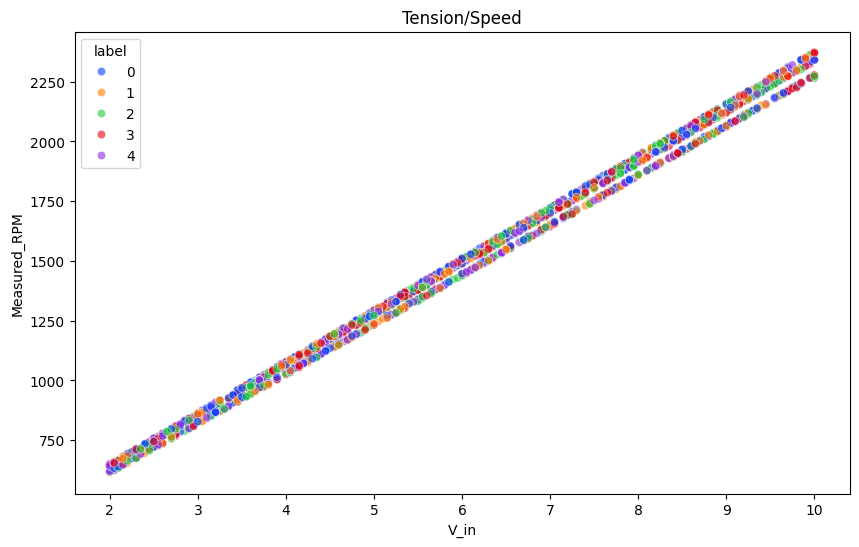

In [6]:
plt.figure(figsize=(10, 6))
sample_plot = df_final.sample(1606, random_state=42)

sns.scatterplot(x='V_in', y='Measured_RPM', hue='label', data=sample_plot,palette="bright", alpha=0.6)
plt.title('Tension/Speed')
plt.show()

The curves for the different classes (Labels 0 to 4) overlap perfectly. This indicates that the level of imbalance does not affect the rotation speed for a given voltage.

This also indicates that the data collected is consistent with actual physical phenomena.

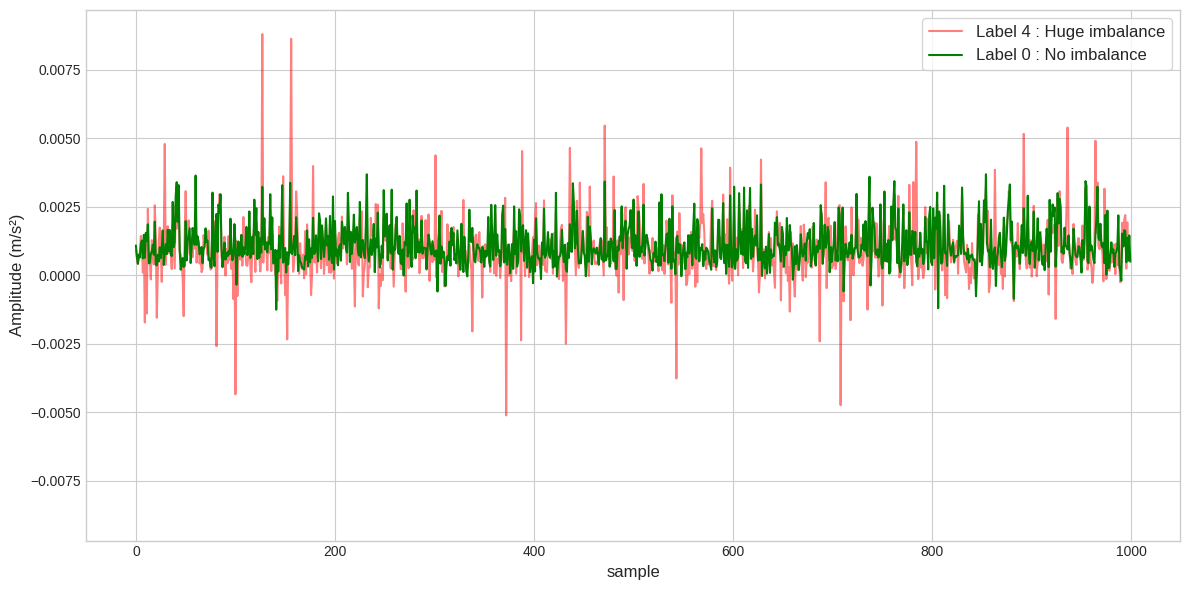

In [7]:
N_POINTS = 1000
plt.figure(figsize=(12, 6))
plt.style.use('seaborn-v0_8-whitegrid')

vib_sain = df_final[df_final['label'] == 0]['Vibration_2'].iloc[:N_POINTS].values
vib_defaut = df_final[df_final['label'] == 4]['Vibration_2'].iloc[:N_POINTS].values

plt.plot(vib_defaut, color='red', alpha=0.5, label='Label 4 : Huge imbalance')
plt.plot(vib_sain, color='green', linewidth=1.5, label='Label 0 : No imbalance')
plt.ylabel("Amplitude (m/s²)", fontsize=12)
plt.xlabel("sample", fontsize=12)
plt.legend(fontsize=12, loc='upper right', frameon=True)

limit = max(abs(vib_defaut)) * 1.1
plt.ylim(-limit, limit)

plt.tight_layout()
plt.show()


Generally, we might expect a vibration to be represented as a wave by a sinusoidal signal. However, due to noise, assembly inaccuracies, and measurement inaccuracies, this is not always possible.

However, important information can still be obtained by working with the mean, or by creating other features such as skewness, kurtosis, or the crest factor.

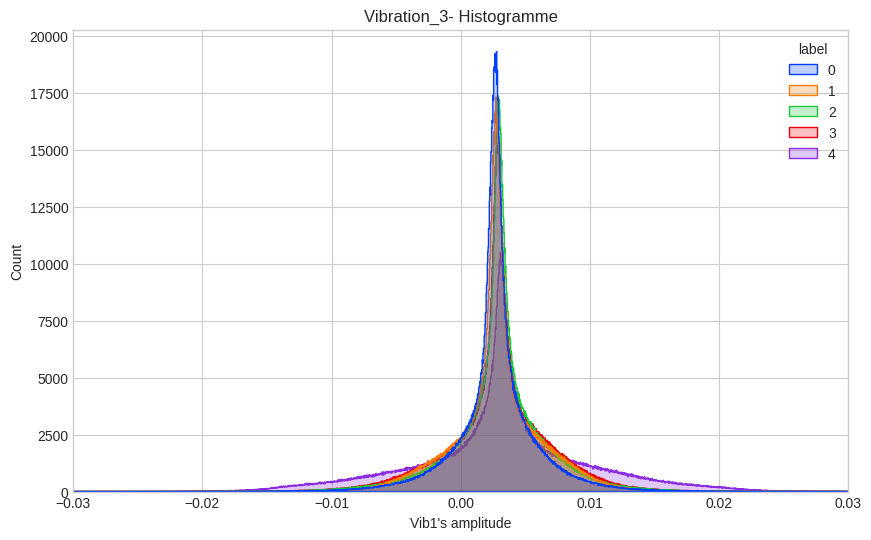

In [8]:
plt.figure(figsize=(10, 6))

sns.histplot(data=df_final,x='Vibration_3',hue='label',palette="bright",element="step")
plt.title('Vibration_3- Histogramme')
plt.xlabel("Vib1's amplitude")

plt.xlim(-0.03, 0.03) #ZOOM
plt.show()

Imbalance does not change the signal's mean, but it increases its variance (the amplitude of the shaking is stronger).

In [9]:
df_fft_final= df_final.copy()

FS = 4096
VIBRATION_COLS = ['Vibration_1', 'Vibration_2', 'Vibration_3']
WINDOW_SIZE = 650 # best window size found

def extract_all_features(signal, fs=FS):
    N = len(signal)

    feats_temp = {'rms': np.sqrt(np.mean(signal**2)),'peak_to_peak': np.max(signal) - np.min(signal),'crest_factor': np.max(np.abs(signal)) / (np.sqrt(np.mean(signal**2)) if np.mean(signal**2) != 0 else 1), 'skewness': skew(signal),'kurtosis': kurtosis(signal)}

    # ---- Features FFT ----
    fft_vals = np.abs(rfft(signal))
    fft_freq = rfftfreq(N, 1/fs)

    idx_max = np.argmax(fft_vals)
    feats_fft = {'freq_pic': fft_freq[idx_max],'amp_pic': fft_vals[idx_max],}
    energy_bands = {'energy_0_50': np.sum(fft_vals[(fft_freq>=0) & (fft_freq<50)]**2),'energy_50_100': np.sum(fft_vals[(fft_freq>=50) & (fft_freq<100)]**2),'energy_100_200': np.sum(fft_vals[(fft_freq>=100) & (fft_freq<200)]**2)}

    return {**feats_temp, **feats_fft, **energy_bands}

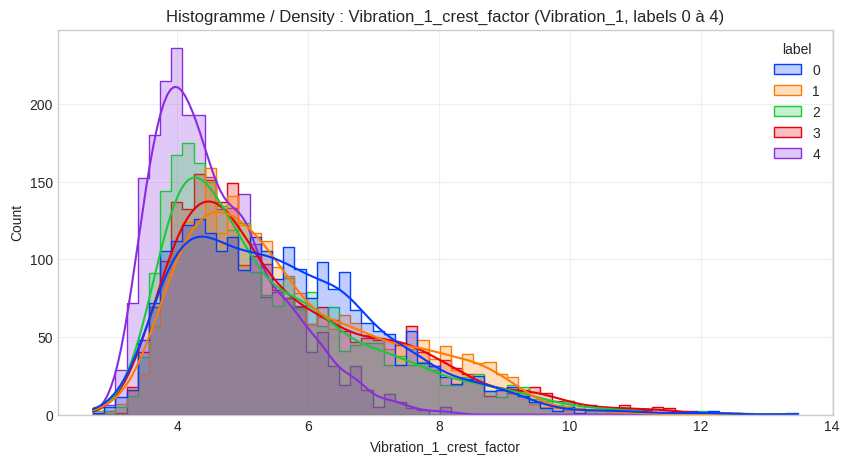

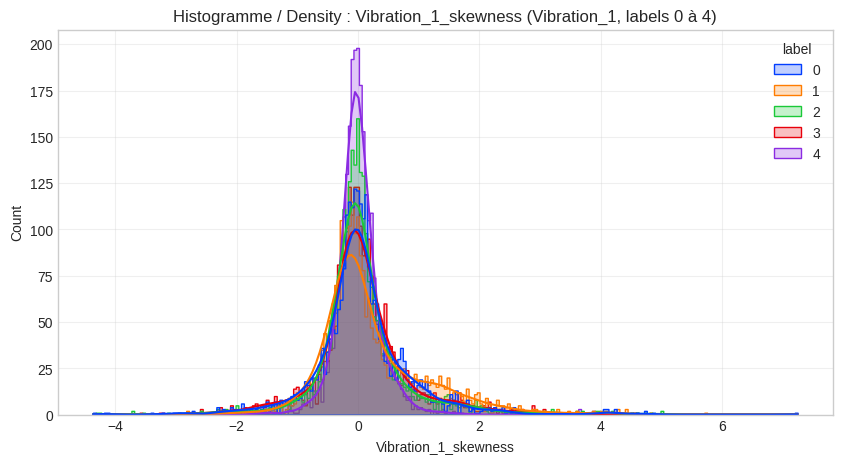

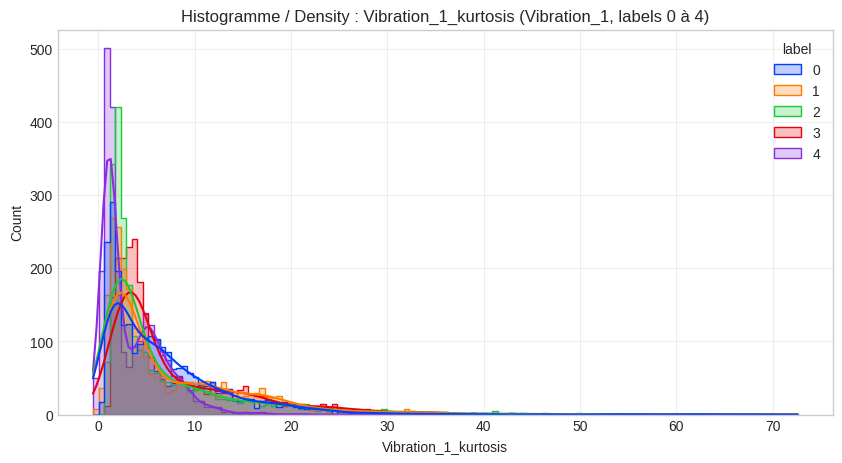

In [11]:
temporal_features_v1 = ['Vibration_1_crest_factor','Vibration_1_skewness','Vibration_1_kurtosis']

for feat in temporal_features_v1:
    if feat in df_features.columns:  # Complile next cell of code beforehand
        plt.figure(figsize=(10, 5))
        sns.histplot(data=df_features,x=feat,hue='label',element="step",palette="bright",kde=True)
        plt.title(f"Histogramme / Density : {feat} (Vibration_1, labels 0 à 4)")
        plt.xlabel(feat)
        plt.grid(True, alpha=0.3)

        plt.show()

With these new temporal features, the difference between label 4 and label 0 becomes clearly apparent, as the signals in label 4 exhibit significantly more extreme and characteristic values.

In contrast, the separation between labels 1, 2, and 3 remains more subtle: their distributions of kurtosis, skewness, and crest factor overlap more, demonstrating that these temporal features alone are still insufficient to accurately distinguish these three intermediate states.

# Limits of the Time-Domain Approach

By training an XGBoost model solely on time-domain data, we observe that performance — particularly the F1 score — quickly reaches a plateau around 0.7.

Result: **inevitable confusion** between classes 1, 2 and 3

# Frequency Analysis (FFT)

To overcome this limit, it therefore becomes relevant to move to the frequency domain, via FFT or other spectral transformations, in order to look for structural differences in the frequency content of the signal and thus better separate labels 1, 2 and 3.

In [10]:
fft_feature_list = []
print(f" we extract in window of {WINDOW_SIZE} lines")
for label in sorted(df_fft_final['label'].unique()):
    df_label = df_final[df_fft_final['label'] == label].reset_index(drop=True)
    n_windows = len(df_label) // WINDOW_SIZE

    for i in range(n_windows):
        start = i * WINDOW_SIZE
        end = (i + 1) * WINDOW_SIZE
        window = df_label.iloc[start:end]

        features_row = {}
        for col in VIBRATION_COLS:
            feats = extract_all_features(window[col].values)
            for k, v in feats.items():
                features_row[f"{col}_{k}"] = v

        features_row['Measured_RPM_mean'] = window['Measured_RPM'].mean()
        features_row['label'] = label
        fft_feature_list.append(features_row)

df_features = pd.DataFrame(fft_feature_list)

 we extract in window of 650 lines


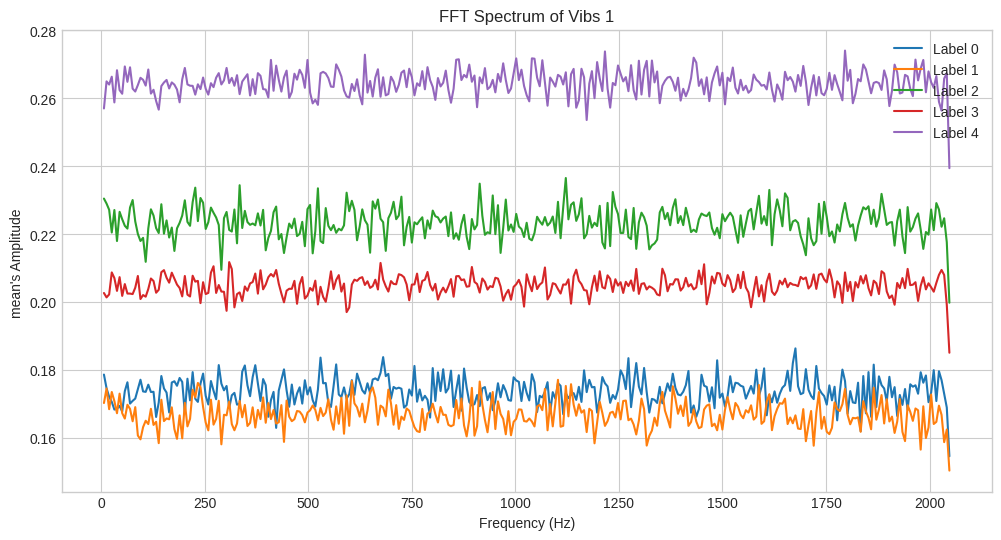

In [12]:
plt.figure(figsize=(12,6))

for label in sorted(df_final['label'].unique()):
    df_label = df_final[df_final['label'] == label].reset_index(drop=True)
    n_windows = len(df_label) // WINDOW_SIZE
    fft_accum = np.zeros(WINDOW_SIZE//2 + 1)

    for i in range(n_windows):
        window = df_label['Vibration_1'].iloc[i*WINDOW_SIZE:(i+1)*WINDOW_SIZE].values
        fft_vals = np.abs(rfft(window))
        fft_accum += fft_vals

    fft_mean = fft_accum / n_windows
    xf = rfftfreq(WINDOW_SIZE, 1/FS)

    xf_plot = xf[1:]
    fft_mean_plot = fft_mean[1:]

    plt.plot(xf_plot, fft_mean_plot, label=f'Label {label}')

plt.xlabel("Frequency (Hz)")
plt.ylabel("mean's Amplitude ")
plt.title("FFT Spectrum of Vibs 1")
plt.legend()
plt.grid(True)
plt.show()


Thanks to the shift to the frequency domain, the analysis of the average amplitude spectrum as a function of frequency finally reveals a much clearer separation between the different levels of defect.

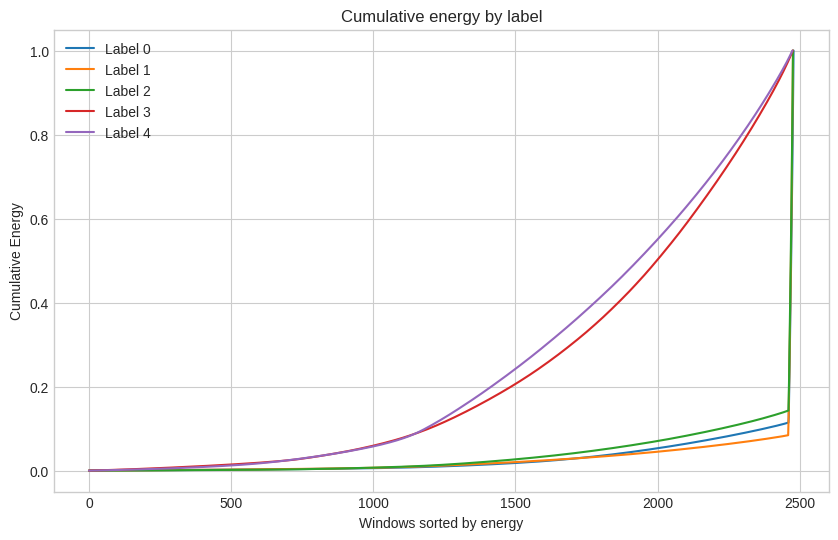

In [13]:
energy_cols = ['Vibration_1_energy_0_50','Vibration_1_energy_50_100','Vibration_1_energy_100_200']
labels = sorted(df_features['label'].unique())
band_labels = ['0-50Hz', '50-100Hz', '100-200Hz']

plt.figure(figsize=(10,6))
for label in labels:
    df_label = df_features[df_features['label'] == label]
    energy_all = df_label[energy_cols].sum(axis=1).sort_values()
    cum_energy = np.cumsum(energy_all) / np.sum(energy_all)
    plt.plot(range(len(energy_all)), cum_energy, label=f'Label {label}')
plt.title("Cumulative energy by label")
plt.xlabel("Windows sorted by energy")
plt.ylabel("Cumulative Energy")
plt.grid(True)
plt.legend()
plt.show()



Our analyses show that:

Temporal features clearly distinguish between extreme cases: label 0 (healthy) and label 4 (major defect).

Frequency features separate more clearly labels 1, 2, and 3, which remain too close in the temporal domain.

 ==> The two domains are therefore complementary.

For this reason, the XGBoost model uses both temporal and frequency features to obtain a reliable classification for all labels.

In [14]:
X = df_features.drop('label', axis=1)
y = df_features['label']

scaler = StandardScaler() # scaling
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)


xgb_model_gs = XGBClassifier(objective='multi:softmax',num_class=len(y.unique()),seed=42,use_label_encoder=False,eval_metric='mlogloss',n_jobs=-1)
param_grid = {'max_depth': [7, 9, 11],'learning_rate': [0.05, 0.1],'reg_alpha': [0.001, 0.01],'n_estimators': [200, 400]}

f1_weighted_scorer = make_scorer(f1_score, average='weighted')
grid_search = GridSearchCV(estimator=xgb_model_gs,param_grid=param_grid,scoring=f1_weighted_scorer,cv=3,verbose=3)
grid_search.fit(X_train, y_train)

print(f"Best parameter : {grid_search.best_params_}")
print(f"Best F1-Score CV : {grid_search.best_score_:.4f}")

best_xgb_model = grid_search.best_estimator_


print("\n--- Résultats d'Évaluation du Modèle Optimisé ---")
y_pred = best_xgb_model.predict(X_test)
print("Classification report :\n")
print(classification_report(y_test, y_pred, digits=4))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel("Label predicted")
plt.ylabel("Real label")
plt.title("Confusion")
plt.show()


importance = pd.Series(best_xgb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
importance.nlargest(10).plot(kind='barh')
plt.title("Top 10 Importance des Features (Modèle Optimisé)")
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.939 total time=  13.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.930 total time=  11.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.935 total time=   9.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.938 total time=  12.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.932 total time=  12.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.935 total time=  10.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.947 total time=  16.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.940 total time=  18.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.942 total time=  16.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.947 total time=  16.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.939 total time=  18.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.941 total time=  16.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.939 total time=  14.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.929 total time=  14.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.933 total time=  15.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.937 total time=  16.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.928 total time=  14.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.931 total time=  14.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:23:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.947 total time=  22.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:24:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.934 total time=  25.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:24:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.940 total time=  21.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.946 total time=  22.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.934 total time=  23.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.937 total time=  20.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.940 total time=  18.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.929 total time=  16.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.932 total time=  16.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:27:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.939 total time=  18.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:27:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.927 total time=  16.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:27:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.931 total time=  16.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:27:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.944 total time=  24.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:28:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.932 total time=  23.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:28:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.936 total time=  23.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:29:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.943 total time=  23.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:29:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.934 total time=  22.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:29:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.05, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.936 total time=  23.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:30:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.949 total time=   9.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:30:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.939 total time=   9.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:30:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.001;, score=0.942 total time=   7.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:30:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.949 total time=   9.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:30:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.940 total time=   9.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=200, reg_alpha=0.01;, score=0.940 total time=   7.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.950 total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.942 total time=  12.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.001;, score=0.943 total time=  12.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.951 total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:31:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.941 total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:32:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=7, n_estimators=400, reg_alpha=0.01;, score=0.943 total time=  12.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:32:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.946 total time=  10.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:32:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.934 total time=  10.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:32:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.001;, score=0.937 total time=  10.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:32:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.947 total time=   9.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:33:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.933 total time=  10.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:33:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=9, n_estimators=200, reg_alpha=0.01;, score=0.937 total time=  10.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:33:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.949 total time=  14.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:33:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.936 total time=  13.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:33:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.001;, score=0.939 total time=  14.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:34:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.947 total time=  14.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:34:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.937 total time=  15.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:34:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=9, n_estimators=400, reg_alpha=0.01;, score=0.941 total time=  14.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:34:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.942 total time=  11.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.934 total time=   9.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.001;, score=0.935 total time=  11.7s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.943 total time=  12.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.933 total time=  11.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:35:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=11, n_estimators=200, reg_alpha=0.01;, score=0.936 total time=  11.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:36:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.945 total time=  14.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:36:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.938 total time=  14.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:36:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.001;, score=0.938 total time=  17.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:36:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 1/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.947 total time=  15.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:37:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 2/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.938 total time=  15.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:37:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV 3/3] END learning_rate=0.1, max_depth=11, n_estimators=400, reg_alpha=0.01;, score=0.939 total time=  15.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:37:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameter : {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 400, 'reg_alpha': 0.01}
Best F1-Score CV : 0.9453

--- Résultats d'Évaluation du Modèle Optimisé ---
Classification report :

              precision    recall  f1-score   support

           0     0.9756    0.9677    0.9717       496
           1     0.9677    0.9677    0.9677       496
           2     0.8962    0.9071    0.9016       495
           3     0.9059    0.8949    0.9004       495
           4     0.9880    0.9960    0.9920       495

    accuracy                         0.9467      2477
   macro avg     0.9467    0.9467    0.9467      2477
weighted avg     0.9467    0.9467    0.9467      2477



NameError: name 'n' is not defined